In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras

from keras.layers import (Input, Dense, Dropout, Activation, Flatten, Convolution2D, 
                          MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate)
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model, model_from_json, load_model
from keras.regularizers import l2
from keras.preprocessing import image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The file ../content/drive/MyDrive/Colab Notebooks/neyro/6/cityscapes_data/train/ does not exist.
(256, 512, 3)
2975


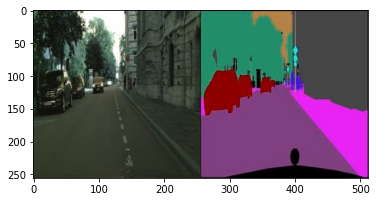

In [3]:
path = '../content/drive/MyDrive/Colab Notebooks/neyro/6/cityscapes_data/train/'
if os.path.isfile(path):
    img1 = cv2.imread(path, 0)
else:
    print ("The file " + path + " does not exist.")

flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
plt.imshow(img0)
print(np.shape(img0))
print(len(flist))

In [4]:
# чтение картинок и создание тренировочного датасета
szy, szx, _ = np.shape(img0)
N_ex = 500
N_bias = 0
x_train = np.zeros((N_ex, szy, int(szx/2), 3))
y_train = np.zeros((N_ex, szy, int(szx/2), 3))
k = 0

for f in flist[N_bias:N_bias+N_ex]:
    x_train[k] = cv2.imread(path+f)[:,:256]/256
    y_train[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

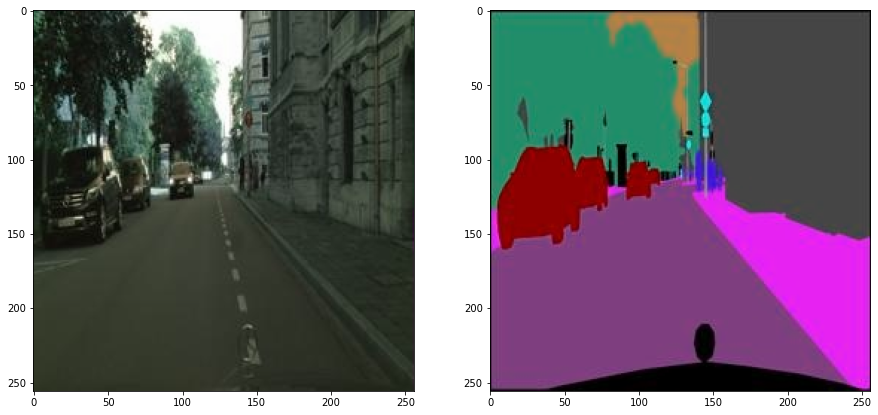

In [5]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.imshow(y_train[0]);

In [6]:
#тренировочные данные
path = '../content/drive/MyDrive/Colab Notebooks/neyro/6/cityscapes_data/val/'

if os.path.isfile(path):
    img1 = cv2.imread(path, 0)
else:
    print ("The file " + path + " does not exist.")

flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
N_val = 50 

szy,szx,_ = np.shape(img0)
x_val = np.zeros((N_val,szy,int(szx/2),3))
y_val = np.zeros((N_val,szy,int(szx/2),3))
k = 0;

for f in flist[0:N_val]:
    x_val[k] = cv2.imread(path+f)[:,:256]/256
    y_val[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

The file ../content/drive/MyDrive/Colab Notebooks/neyro/6/cityscapes_data/val/ does not exist.


In [7]:
from keras.layers import BatchNormalization

In [8]:
from tensorflow.keras.optimizers import Adam

In [9]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [10]:
def Unet(num_classes=14, input_shape=(256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    block_1_out = Activation('relu')(x)


    x = MaxPooling2D()(block_1_out)


    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    block_4_out = Activation('relu')(x)

    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
 
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

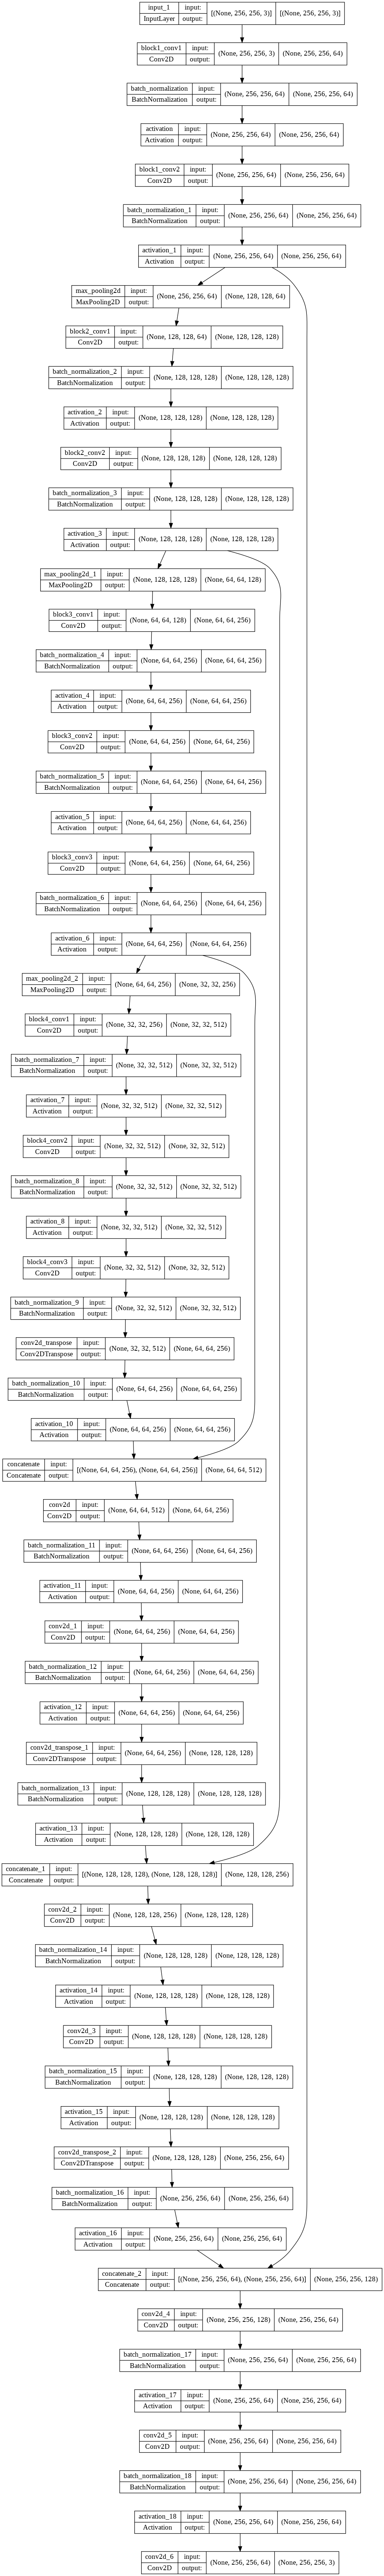

In [11]:
model_1 = Unet(3, (256, 256, 3))

plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [12]:
model_1.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef]) # самописная метрика dice
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [13]:
history_1 = model_1.fit(x_train, y_train,
                      epochs=20,
                      batch_size=10,
                      validation_data=(x_val, y_val),
                      )

Epoch 1/20
50/50 [==============================] - 81s 1s/step - loss: 1.1959 - dice_coef: 0.3715 - val_loss: 8.7955 - val_dice_coef: 0.2674
Epoch 2/20
50/50 [==============================] - 60s 1s/step - loss: 1.1646 - dice_coef: 0.3683 - val_loss: 1.2038 - val_dice_coef: 0.3368
Epoch 3/20
50/50 [==============================] - 60s 1s/step - loss: 1.1701 - dice_coef: 0.3674 - val_loss: 1.1416 - val_dice_coef: 0.3392
Epoch 4/20
50/50 [==============================] - 59s 1s/step - loss: 1.1728 - dice_coef: 0.3686 - val_loss: 1.3365 - val_dice_coef: 0.3448
Epoch 5/20
50/50 [==============================] - 59s 1s/step - loss: 1.1768 - dice_coef: 0.3692 - val_loss: 1.1748 - val_dice_coef: 0.3487
Epoch 6/20
50/50 [==============================] - 60s 1s/step - loss: 1.1738 - dice_coef: 0.3698 - val_loss: 1.5490 - val_dice_coef: 0.3539
Epoch 7/20
50/50 [==============================] - 59s 1s/step - loss: 1.1780 - dice_coef: 0.3710 - val_loss: 1.1922 - val_dice_coef: 0.3642
Epoch 

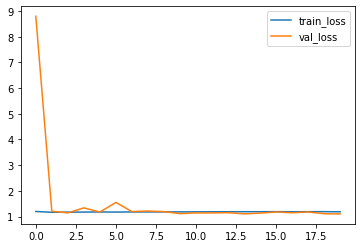

In [14]:
plt.plot(history_1.history['loss'], label='train_loss')
plt.plot(history_1.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

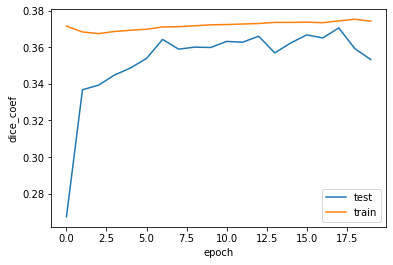

In [15]:
plt.plot(history_1.history['val_dice_coef'], label='test')
plt.plot(history_1.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [16]:
pred_1 = model_1.predict(x_val)
print(pred_1.shape)

(50, 256, 256, 3)


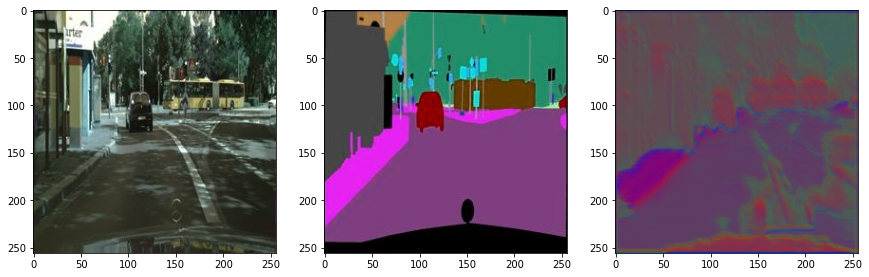

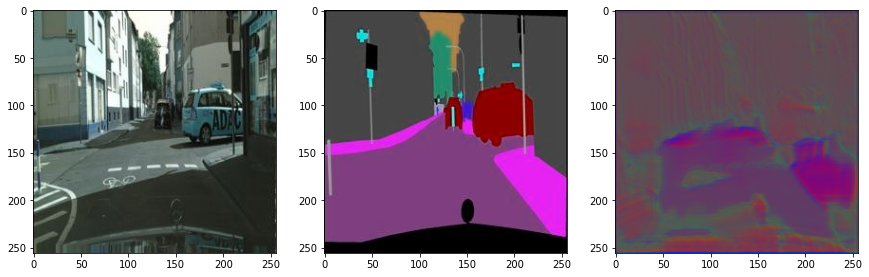

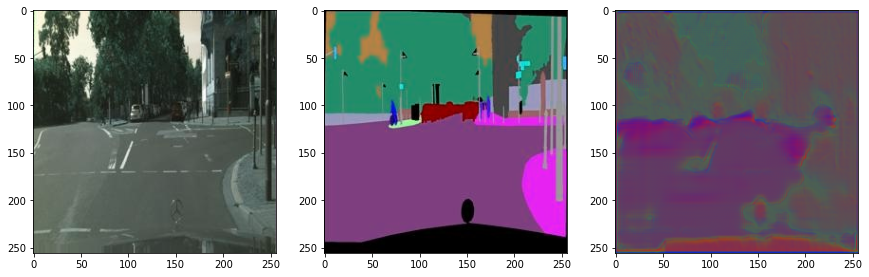

In [17]:
ni = 3
for k in range(ni):
    plt.figure(figsize=(20,60))

    plt.subplot(ni,4,1+k*4)
    plt.imshow(x_val[k])

    plt.subplot(ni,4,2+k*4)
    plt.imshow(y_val[k])

    plt.subplot(ni,4,3+k*4)
    plt.imshow(pred_1[k])

(1, 256, 256)


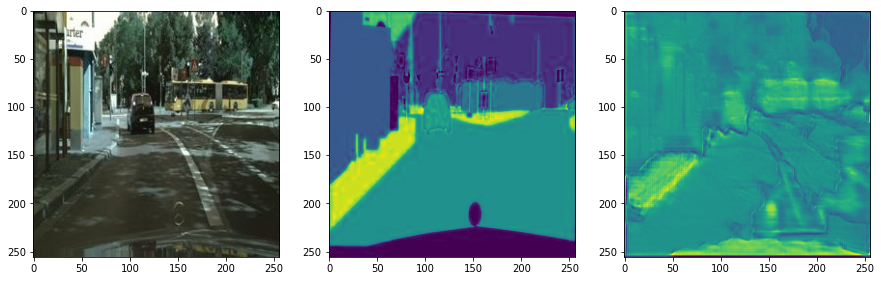

In [18]:
def show_predictions(model):

    sample_image = x_val[0]
    sample_mask = y_val[0]

    pred_mask = model.predict(sample_image[None])[..., 0] # нулевой канал, можно любой (можно которого больше)
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image) # картинка
    ax[1].imshow(sample_mask[..., 0]) # истиная маска
    ax[2].imshow(np.squeeze(pred_mask, axis=0)) # предсказаная маска
    plt.show()

# исходная картинка, истинная маска, предсказанная маска
show_predictions(model_1)

Улучшение качества происходит при увеличении эпох и добавления слоев обработки, но цена значительно увеличивается.